# 囚人のジレンマを対象とした強化学習：協調動作（2つのエージェントが学習）

## ライブラリのインストール

In [1]:
!pip install axelrod

## ライブラリのインポート

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import axelrod as axl

## 対戦数の設定

In [3]:
NUM_MATCH = 5
#0:C(協調), 1:D(裏切り)

## エージェントクラス
状態を観測し、行動を決定し、状態・行動・報酬からQ値を更新する

In [4]:
class Agent():
    def __init__(self):
        self.QV = np.zeros((3**2, 2))
    def GetAction(self, epsilon, opponent_history, player_history):
        if(len(opponent_history)==0):#1回目の状態は0
            self.state = 0
        elif(len(opponent_history)==1):#2回目の状態は相手の1手目だけから作成
            self.state = 1 if opponent_history[0]==C else 2
        else:#3回目以降の状態は相手の最後の2手から作成
            self.state = (1 if opponent_history[-1]==C else 2) + (1 if opponent_history[-2]==C else 2)*3

        if epsilon > np.random.random():#徐々に最適行動のみをとる、ε-greedy法
            self.action = np.random.choice([0, 1])
        else:
            a = np.where(self.QV[self.state]==self.QV[self.state].max())[0]
            self.action = np.random.choice(a)
        return self.action
    def UpdateQValue(self, state, next_state, action, reward):
        alpha, gamma = 0.5, 0.8
        next_maxQ=max(self.QV[next_state])
        self.QV[state, action] = (1 - alpha) * self.QV[state, action] + alpha * (reward + gamma * next_maxQ)
    def Update(self, mp, ms):
        for i in range(NUM_MATCH):
            if i==0:#1手目を学習するための状態と次の状態の作成
                state = 0
                next_state = (1 if mp[i][1]==C else 2)
            else:#2手目以降を学習するための状態と次の状態の作成
                state = next_state
                next_state = (1 if mp[i][1]==C else 2) + (1 if mp[i-1][1]==C else 2)*3
            action = 0 if mp[i][0]==C else 1
            reward = 0
            if i==NUM_MATCH-1:
#                reward = (float(ms[0]-ms[1])/NUM_MATCH)**3#対立動作の時の報酬
#                reward = -np.abs((float(ms[0]-ms[1])/NUM_MATCH)**3)#得点差に比例してマイナスの報酬
                reward = (float(ms[0]+ms[1])/NUM_MATCH)**3#合計点を大きくする
            self.UpdateQValue(state, next_state, action, reward)

## 2つのエージェント戦略の作成

In [5]:
from axelrod.strategy_transformers import *

A1 = Agent()
class MyStrategy1(Player):
    name = "MyStrategy1"
    def strategy(self, opponent):
        global A1, epsilon
        act = A1.GetAction(epsilon,opponent.history, self.history)
        if act == 0:
            return C
        return D

In [6]:
A2 = Agent()
class MyStrategy2(Player):
    name = "MyStrategy2"
    def strategy(self, opponent):
        global A2, epsilon
        act = A2.GetAction(epsilon,opponent.history, self.history)
        if act == 0:
            return C
        return D

## 学習のための試行の繰り返し

In [7]:
np.random.seed(0)

num_episode=100000
result = []
for episode in range(num_episode):
    epsilon = float(num_episode-episode)/num_episode
    match = axl.Match([MyStrategy1(), MyStrategy2()], NUM_MATCH)
    mp = match.play()
    ms1 = match.final_score()
    ms2 = (ms1[1],ms1[0])
    A1.Update(mp,ms1)
    A2.Update(mp,ms2)
    if episode%1000==0:
#        result.append(ms1[1]-ms1[0])#得点差に比例してマイナスの報酬
        result.append(ms1[1]+ms1[0])#合計点を大きくする
        print(episode//1000,ms1)

epsilon=0
match = axl.Match([MyStrategy1(), MyStrategy2()], NUM_MATCH)
mp = match.play()
ms = match.final_score()
print(mp)
print(ms)
print(A1.QV)
print(A2.QV)


0 (17, 7)
1 (12, 12)
2 (12, 7)
3 (21, 6)
4 (12, 12)
5 (12, 7)
6 (16, 6)
7 (15, 10)
8 (18, 8)
9 (8, 13)
10 (12, 12)
11 (7, 12)
12 (8, 18)
13 (6, 11)
14 (13, 13)
15 (10, 10)
16 (12, 12)
17 (4, 19)
18 (8, 13)
19 (16, 11)
20 (11, 11)
21 (12, 7)
22 (8, 13)
23 (19, 4)
24 (10, 10)
25 (14, 9)
26 (13, 3)
27 (8, 13)
28 (9, 14)
29 (17, 7)
30 (11, 16)
31 (25, 0)
32 (18, 8)
33 (11, 16)
34 (7, 12)
35 (5, 15)
36 (6, 16)
37 (15, 5)
38 (12, 12)
39 (14, 14)
40 (3, 23)
41 (16, 6)
42 (14, 9)
43 (6, 16)
44 (6, 16)
45 (19, 4)
46 (5, 15)
47 (10, 10)
48 (25, 0)
49 (8, 8)
50 (13, 8)
51 (11, 6)
52 (19, 9)
53 (14, 9)
54 (13, 13)
55 (13, 13)
56 (9, 14)
57 (23, 3)
58 (7, 17)
59 (5, 15)
60 (14, 14)
61 (9, 19)
62 (12, 7)
63 (14, 9)
64 (16, 11)
65 (12, 17)
66 (9, 14)
67 (9, 19)
68 (9, 9)
69 (7, 7)
70 (1, 21)
71 (17, 7)
72 (7, 17)
73 (15, 10)
74 (12, 17)
75 (17, 12)
76 (13, 8)
77 (15, 15)
78 (12, 12)
79 (5, 15)
80 (15, 15)
81 (7, 17)
82 (15, 15)
83 (15, 5)
84 (15, 10)
85 (15, 5)
86 (14, 14)
87 (13, 13)
88 (11, 11)
89 

## 学習による報酬の変化

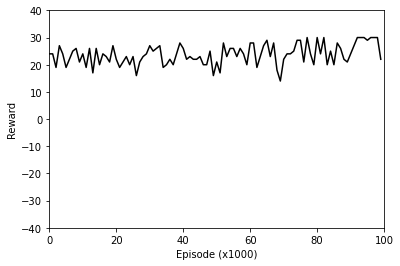

In [8]:
import matplotlib.pyplot as plt

plt.plot(result, color='k')
plt.xlabel("Episode (x1000)")
plt.ylabel("Reward")
plt.xlim(0, 100)
plt.ylim(-40, 40)
plt.savefig("PD2coop2.pdf")
plt.savefig('PD2coop2.png')
plt.show()
